### installs and imports

In [44]:
pip install torch torchvision numpy matplotlib Pathlib -qqq


In [45]:

import os
from pathlib import Path
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Load Dataset from Kaggle

In [46]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Split the data into train val, and test set (starified)

In [47]:
dataset_path = Path(path)

In [48]:
image_paths = []
labels = []

for file_name in os.listdir(dataset_path):
    if file_name.endswith(".png"):
        image_paths.append(Path(dataset_path) / file_name)
        labels.append(int(file_name[1]))

print(image_paths[:5])
print(labels[:5])

[PosixPath('/kaggle/input/horse-breeds/01_103.png'), PosixPath('/kaggle/input/horse-breeds/03_068.png'), PosixPath('/kaggle/input/horse-breeds/02_060.png'), PosixPath('/kaggle/input/horse-breeds/03_030.png'), PosixPath('/kaggle/input/horse-breeds/07_065.png')]
[1, 3, 2, 3, 7]


In [49]:
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f"training samples: {len(train_paths)}")
print(f"validation samples: {len(val_paths)}")
print(train_paths[:10])
print(train_labels[:10])
print(val_labels[:10])


training samples: 536
validation samples: 134
[PosixPath('/kaggle/input/horse-breeds/02_004.png'), PosixPath('/kaggle/input/horse-breeds/03_022.png'), PosixPath('/kaggle/input/horse-breeds/02_093.png'), PosixPath('/kaggle/input/horse-breeds/05_033.png'), PosixPath('/kaggle/input/horse-breeds/05_034.png'), PosixPath('/kaggle/input/horse-breeds/02_057.png'), PosixPath('/kaggle/input/horse-breeds/01_066.png'), PosixPath('/kaggle/input/horse-breeds/02_037.png'), PosixPath('/kaggle/input/horse-breeds/05_023.png'), PosixPath('/kaggle/input/horse-breeds/07_073.png')]
[2, 3, 2, 5, 5, 2, 1, 2, 5, 7]
[7, 2, 2, 6, 6, 1, 1, 5, 6, 6]


### Dataset Class

In [50]:
class HorseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


### Transforms


In [51]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_image = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std),
])

* making a dataset without transformation (only for display)

In [52]:
train_original = HorseDataset(train_paths, train_labels)
val_original = HorseDataset(val_paths, val_labels)


* Now making datasets with transformation

In [53]:
train_dataset = HorseDataset(train_paths, train_labels, transform=transform_image)
val_dataset = HorseDataset(val_paths, val_labels, transform=transform_image)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Train: 536, Val: 134


#### Displaying images

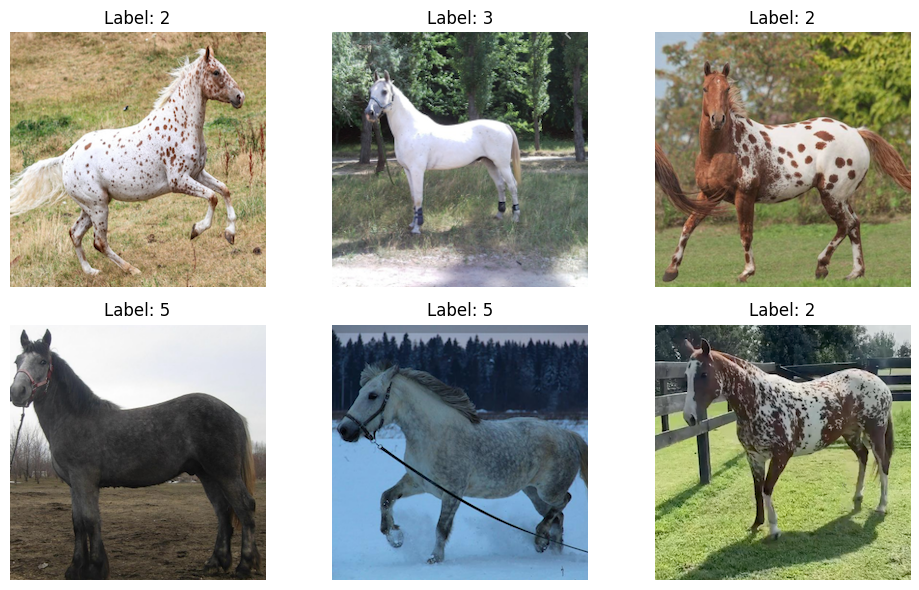

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(6):
    img, label = train_original[i]  
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


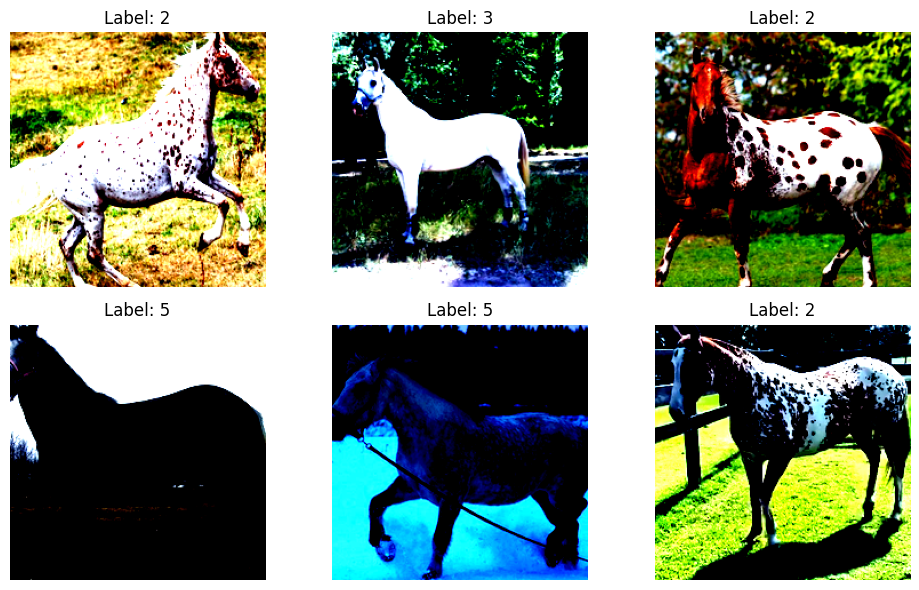

In [55]:
plt.figure(figsize=(10, 6))
for i in range(6):
    img, label = train_dataset[i]  
    img = img.permute(1, 2, 0) 
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Define Model 

### define Loss and Optimizer

#### Build one_epoch_training function loop 

### Combine all to train the model
it should Save the best model and track train and val loss and accuracy


### test the model on test set

### show some predictions with the images

### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

### Load the model